In [13]:
# Author: Yilin ZHENG
# import necessary libraries
import numpy as np
from scipy.io import loadmat
import pandas as pd
import random
from scipy.stats import norm, multivariate_normal
from sys import maxsize
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [2]:
# load data, 4 Gaussian distributions
data = loadmat("./data_c3_2.mat")
cluster_mean = data['cluster_mean']  # means
cluster_std = data['cluster_std']  # standard deviation
ndata = data['ndata'][0][0]  # sample size
ndim = data['ndim'][0]  # dimension of sample, each is a point (x, y)
Y = data['Y']  # sample
perm1 = data['perm1'][0]  # order of samples

In [3]:
print(f"Means:\n{cluster_mean}")
print(f"Standard deviations:\n{cluster_std}")
print(f"Size of each Gaussian distribution: {ndata}")
print(f"Samples size: {len(Y)}")
# print(f"Samples: {Y}")
# print(f"Order of samples:\n{perm1}")

Means:
[[0 0]
 [8 2]
 [1 4]
 [8 2]]
Standard deviations:
[[1.  1. ]
 [1.  2. ]
 [2.  0.5]
 [1.  2. ]]
Size of each Gaussian distribution: 100
Samples size: 400


In [4]:
# number of clusters
K = 3
# initialize parameters
pi = np.random.dirichlet(np.ones(3))
mu = [0]*3 #[np.random.randn() for k in range(K)]
std = [1]*3 #[np.random.randn() for k in range(K)]
print(f"pi: {pi}")
print(f"mu: {mu}")
print(f"std: {std}")

pi: [0.46352667 0.40044351 0.13602982]
mu: [0, 0, 0]
std: [1, 1, 1]


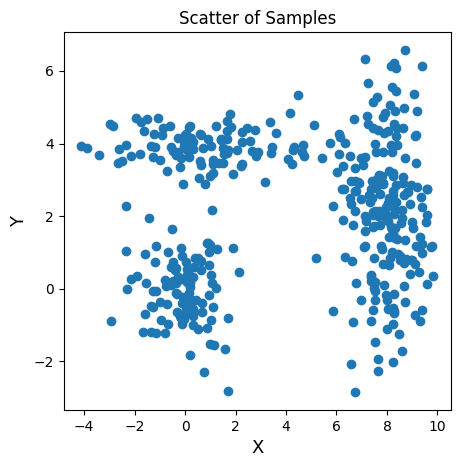

In [5]:
plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(Y[:,0], Y[:,1])
plt.xlabel("X", fontsize=13)
plt.ylabel("Y", fontsize=13)
plt.title("Scatter of Samples")
plt.show()

In [48]:
# GMM model with EM method
# Reference: https://github.com/celisun/Expectation_Maximization_algoritihm_implementation_for_Gaussian_Mixture_Model
class GMM_EM():
    def __init__(self, mean_0=None, mean_1=None, mean_2=None,\
                 var_0=None, var_1=None, var_2=None, pi=None):
        self.mean_0 = mean_0
        self.mean_1 = mean_1
        self.mean_2 = mean_2
        self.var_0 = var_0
        self.var_1 = var_1
        self.var_2 = var_2
        self.pi = pi  # sum(pi) == 1
        
        self.data = None
        self.n_data = None
        self.steps = None
        self.gamma = None
        
        self.mean_0_recall = []
        self.mean_1_recall = []
        self.mean_2_recall = []
        self.log_likelihood_recall = []
        self.multi_norm = multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]])
    
    def step(self, data):
        self.n_data, n_feature = data.shape
        self.data = data
        co_variance = np.cov(data, rowvar=True) 
        if self.mean_0 is None:
            mean_x, mean_y = np.mean(data[:,0]), np.mean(data[:,1])
            std_x, std_y = np.std(data[:,0]), np.std(data[:,1])
            self.pi = np.random.dirichlet(np.ones(3)) # [pi_1, pi_2, pi_3]
            self.mean_0 = np.array([np.random.normal(mean_x, std_x),np.random.normal(mean_y, std_y)])   
            self.mean_1 = np.array([np.random.normal(mean_x, std_x),np.random.normal(mean_y, std_y)])
            self.mean_2 = np.array([np.random.normal(mean_x, std_x),np.random.normal(mean_y, std_y)]) 
            cov = np.cov(data, rowvar=False)  
            self.var_0 = np.random.normal([10,10], 1, size=(2))
            self.var_1 = np.random.normal([10,10], 1, size=(2))   
            self.var_2 = np.random.normal([10,10], 1, size=(2))
        self.mean_0_recall.append(self.mean_0.tolist())
        self.mean_1_recall.append(self.mean_1.tolist())
        self.mean_2_recall.append(self.mean_2.tolist())
        l = self.log_likelihood()
        self.log_likelihood_recall.append(l)
        
        MAX_ITER = 50
        for t in range(1, MAX_ITER+1):  
            print("Iteration {}".format(t))
            # EM step
            self.E_step()
            self.M_step()
            
            l_next = self.log_likelihood()
            print ("log-likelihood:    {}".format(l_next))
            self.log_likelihood_recall.append(l_next)
            self.mean_0_recall.append(self.mean_0.tolist())
            self.mean_1_recall.append(self.mean_1.tolist())
            self.mean_2_recall.append(self.mean_2.tolist())
 
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
            self.steps = t
            # converge
            if (l_next - l) < 1e-6 or t > MAX_ITER: 
#                 self.steps = t
                break
            l = l_next
        self.plot()

    def E_step(self):      
        z_0 = (self.data - self.mean_0) / self.var_0 ** 0.5
        z_1 = (self.data - self.mean_1) / self.var_1 ** 0.5
        z_2 = (self.data - self.mean_2) / self.var_2 ** 0.5
        
        a = self.pi[0] * self.multi_norm.pdf(z_0)
        b = self.pi[1] * self.multi_norm.pdf(z_1) 
        c = self.pi[2] * self.multi_norm.pdf(z_2)
        s = a + b + c
        self.gamma_0 = a / s
        self.gamma_1 = b / s
        self.gamma_2 = c / s
    
    def M_step(self, to_print=False):
        wi0 = self.gamma_0.reshape((-1,1))
        wi1 = self.gamma_1.reshape((-1,1)) 
        wi2 = self.gamma_2.reshape((-1,1)) 
        self.mean_0 =  np.sum(wi0 * self.data, 0) / wi0.sum(axis=0)  
        self.mean_1 =  np.sum(wi1 * self.data, 0) / wi1.sum(axis=0)   
        self.mean_2 =  np.sum(wi2 * self.data, 0) / wi2.sum(axis=0)   
        self.var_0 =  np.sum(wi0 * np.sum((self.data - self.mean_0)**2, 1).reshape((-1,1)), 0) / wi0.sum(axis=0)
        self.var_1 =  np.sum(wi1 * np.sum((self.data - self.mean_1)**2, 1).reshape((-1,1)), 0) / wi1.sum(axis=0)
        self.var_2 =  np.sum(wi2 * np.sum((self.data - self.mean_2)**2, 1).reshape((-1,1)), 0) / wi2.sum(axis=0)
        
        self.pi[0] = np.sum(wi0, 0) / self.n_data
        self.pi[1] = np.sum(wi1, 0) / self.n_data
        self.pi[2] = np.sum(wi2, 0) / self.n_data
        print ("mean0: {},  mean1: {}  mean2: {}\nvar0: {},            var1: {},            var2: {}"\
               .format(self.mean_0, self.mean_1, self.mean_2, self.var_0, self.var_1, self.var_2))
    
    def log_likelihood(self):
        z_0 = (self.data - self.mean_0) / self.var_0**0.5   
        z_1 = (self.data - self.mean_1) / self.var_1**0.5
        z_2 = (self.data - self.mean_2) / self.var_2**0.5
        
        p_0 = self.pi[0] * self.multi_norm.pdf(z_0)
        p_1 = self.pi[1] * self.multi_norm.pdf(z_1) 
        p_2 = self.pi[2] * self.multi_norm.pdf(z_2)
        l = np.log(p_0 +p_1 + p_2).sum()   
        return l
    
    def plot(self):
        fig = plt.figure(figsize=(12,12))
        plt.clf()
        ax1 = fig.add_subplot(2,2,1)
        ax2 = fig.add_subplot(2,2,2)
        
        x1,y1 = np.array(self.mean_0_recall).T
        x2,y2 = np.array(self.mean_1_recall).T
        x3,y3 = np.array(self.mean_2_recall).T
        ax1.plot(x1,y1,'-o')
        ax1.plot(x2,y2,'-o')
        ax1.plot(x3,y3,'-o')
        for x,y in [[x1,y1],[x2,y2],[x3,y3]]:
            for i in range(len(x)):
                ax1.annotate(str(i),(x[i],y[i]))
        ax1.legend(['mean_0', 'mean_1', 'mean_2'], loc='best')
        ax2.plot(self.log_likelihood_recall,'-o')
        ax2.set_ylim(bottom=-1200, top=-600)
        ax1.set_title('Trajectory of model parameter \nover iterations during EM')
        ax1.set_ylabel('means')
        ax2.set_ylabel('Log-Likelihood')                
        plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

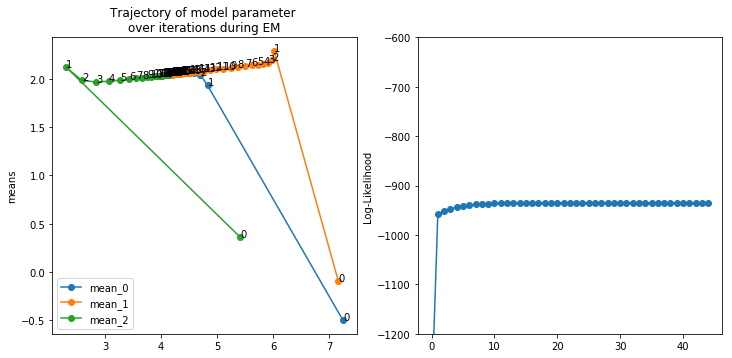

In [7]:
model = GMM_EM()
model.step(Y)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

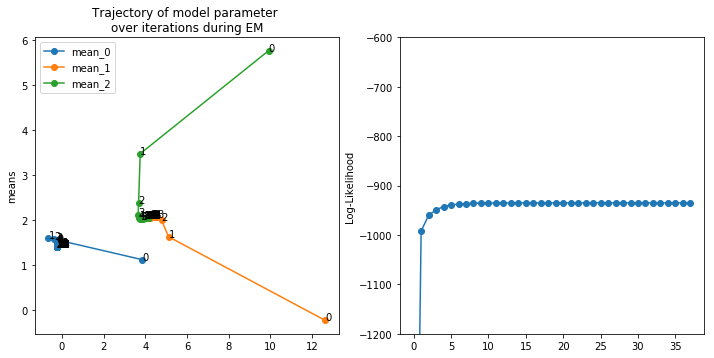

log-likelihood: -935.1  
with centers and variance for 3 clusters: 
 [-0.2398273914252057, 1.3822783708198236], (variance: [5.630240739227358]) 
 [4.129824238665884, 2.040368857761711], (variance: [20.292193754259824]) 
 [4.12891050672758, 2.0403105864248756], (variance: [20.293052967120158])


Over the 50 trails, the distribution of number of steps 
for algorithm to converge and terminate is as follows.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


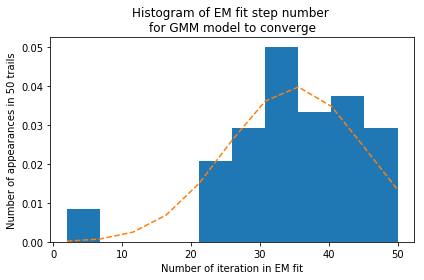

In [8]:
import pylab as pl
import scipy.stats as stats
import matplotlib.mlab as mlab

h, h_score, h_score_traj = [], [], []
h_means, h_vars = [], []
for __ in range(50):
    model = GMM_EM()
    model.step(Y)
    h.append(model.steps)
    h_score.append(model.log_likelihood_recall[-1])
    h_score_traj.append(model.log_likelihood_recall)
    h_means.append([model.mean_0, model.mean_1, model.mean_2])
    h_vars.append([model.var_0, model.var_1, model.var_2])
print ("log-likelihood: {}  \n======================================================"\
       .format(str(model.log_likelihood_recall[-1])[:6]))
print ("with centers and variance for 3 clusters: \n {}, (variance: {}) \n {}, (variance: {}) \n {}, (variance: {})"\
       .format(model.mean_0_recall[-1], model.var_0.tolist(), model.mean_1_recall[-1], model.var_1.tolist(),\
       model.mean_2_recall[-1], model.var_2.tolist())) 

fig, ax = plt.subplots()
n, bins, patches = ax.hist(h, 10, density=1)
y = mlab.normpdf(bins, np.mean(h), np.std(h))
ax.plot(bins, y, '--')
ax.set_xlabel('Number of iteration in EM fit')
ax.set_ylabel('Number of appearances in 50 trails')
ax.set_title('Histogram of EM fit step number \nfor GMM model to converge')
print ("\n\nOver the 50 trails, the distribution of number of steps \nfor algorithm to converge and terminate is as follows.")
fig.tight_layout() 
plt.show() 

# compute best trail
idx = h_score.index(max(h_score))
c1, c2, c3 = h_means[idx]

In [9]:
from sklearn.cluster import KMeans
def K_Means_GMM_EM():
    k_means = KMeans(n_clusters=3, random_state=0).fit(Y)
    Y_labels = k_means.labels_
    center0, center1, center2 = k_means.cluster_centers_
    
    # compute var, pi, mean based on K-means clustering results
    var_0 = np.var([Y[i].tolist() for i in range(len(Y_labels)) if Y_labels[i] == 0 ], axis=0)
    var_1 = np.var([Y[i].tolist() for i in range(len(Y_labels)) if Y_labels[i] == 1 ], axis=0)
    var_2 = np.var([Y[i].tolist() for i in range(len(Y_labels)) if Y_labels[i] == 2 ], axis=0)
    
    pi = [np.count_nonzero(Y_labels == 0)/len(Y_labels),\
          np.count_nonzero(Y_labels == 1)/len(Y_labels),\
          np.count_nonzero(Y_labels == 2)/len(Y_labels)]

    k_model = GMM_EM(mean_0=center0,
                     mean_1=center1,
                     mean_2=center2,
                     var_0=var_0,
                     var_1=var_1,
                     var_2=var_2,
                     pi=pi)
    return k_model, center0, center1, center2 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

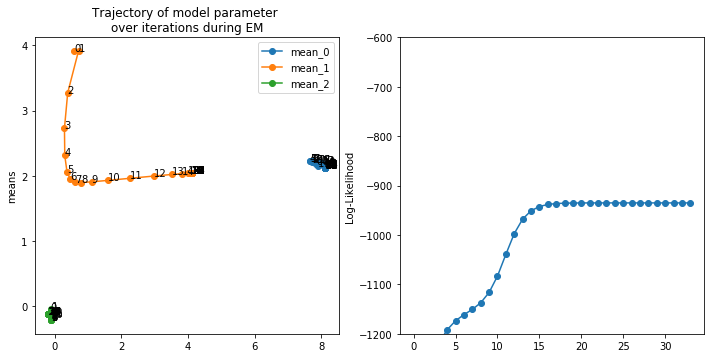

log-likelihood: -935.1  
with centers and variance for 3 clusters: 
 [8.109618500594992, 2.1227504490902267], [2.033850104696087] 
 [4.129581815965707, 2.040353397984396], [20.2924218741368] 
 [-0.18737239213113518, -0.12163753005180972], [0.740584061769483]


In [10]:
k_model, center0, center1, center2 = K_Means_GMM_EM()
k_model.step(Y)
print ("log-likelihood: {}  \n=================".format(str(k_model.log_likelihood_recall[-1])[:6]))
print ("with centers and variance for 3 clusters: \n {}, {} \n {}, {} \n {}, {}"\
       .format(k_model.mean_0_recall[-1], k_model.var_0.tolist(), \
               k_model.mean_1_recall[-1], k_model.var_1.tolist(), \
               k_model.mean_2_recall[-1], k_model.var_2.tolist())) 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

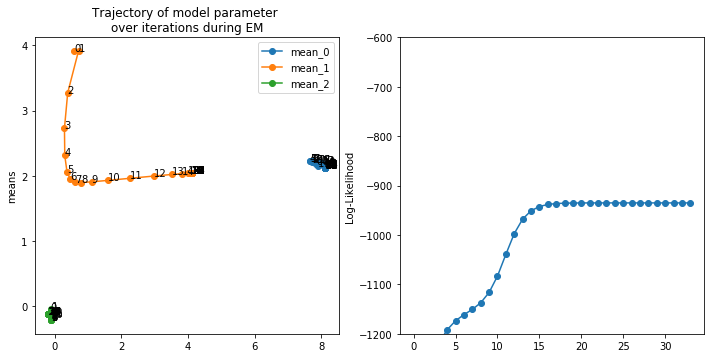

In [11]:
hk = []
hk_score = []
c1, c2, c3 = None, None, None
for __ in range(50):
    k_model, c1, c2, c3 = K_Means_GMM_EM()
    k_model.step(Y)
    hk.append(k_model.steps)
    hk_score.append(k_model.log_likelihood_recall[-1])


The centers obtained are:
k-means ini: c1: (8.10, 2.12), c2: (4.12, 2.04), c3: (-0.1, -0.1)


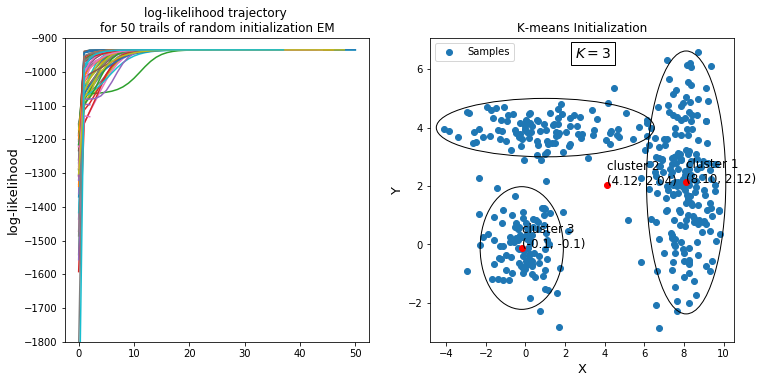

In [47]:
print ("\nThe centers obtained are:")
print ("k-means ini: c1: ({}, {}), c2: ({}, {}), c3: ({}, {})"\
       .format(str(k_model.mean_0[0])[:4], str(k_model.mean_0[1])[:4],\
               str(k_model.mean_1[0])[:4], str(k_model.mean_1[1])[:4], \
               str(k_model.mean_2[0])[:4], str(k_model.mean_2[1])[:4]))

fig = plt.figure(figsize=(12,19)) 

ax1 = fig.add_subplot(3,2,1) 

for traj in h_score_traj:
    ax1.plot(traj)
ax1.set_ylim(bottom=-1800, top=-900)
ax1.set_ylabel("log-likelihood", fontsize=13)
ax1.set_title("log-likelihood trajectory \nfor 50 trails of random initialization EM")

ax2 = fig.add_subplot(3,2,2) 
ax2.scatter(Y[:,0], Y[:,1])
ax2.scatter(k_model.mean_0[0], k_model.mean_0[1], c="red")
ax2.scatter(k_model.mean_1[0], k_model.mean_1[1], c="red")
ax2.scatter(k_model.mean_2[0], k_model.mean_2[1], c="red")
ax2.set_title("K-means Initialization") 
ax2.set_xlabel("X", fontsize=13) 
ax2.set_ylabel("Y", fontsize=13)
ax2.legend(['Samples'], loc='best')
ax2.annotate("cluster 1\n({}, {})".format(str(k_model.mean_0[0])[:4], str(k_model.mean_0[1])[:4]), \
             (k_model.mean_0[0], k_model.mean_0[1]), fontsize=12)
ax2.annotate("cluster 2\n({}, {})".format(str(k_model.mean_1[0])[:4], str(k_model.mean_1[1])[:4]), \
             (k_model.mean_1[0], k_model.mean_1[1]),fontsize=12)
ax2.annotate("cluster 3\n({}, {})".format(str(k_model.mean_2[0])[:4], str(k_model.mean_2[1])[:4]), \
             (k_model.mean_2[0], k_model.mean_2[1]),fontsize=12)
ax2.annotate("$K=3$",
            xy=(2.5, 6.4), 
            size=14,
            bbox=dict(boxstyle="square", fc=(1, 1, 1), ec="black"))
e1 = Ellipse(xy = (k_model.mean_0[0], k_model.mean_0[1]), width = 4.5 * 2, height = 2.0 * 2, angle=90, \
            edgecolor="black", fill=False)
e2 = Ellipse(xy = (1.0, 4.0), width = 5.5 * 2, height = 1.0 * 2, angle=0, \
            edgecolor="black", fill=False)
e3 = Ellipse(xy = (k_model.mean_2[0], k_model.mean_2[1]), width = 2.1 * 2, height = 2.1 * 2, angle=0, \
            edgecolor="black", fill=False)
ax2.add_artist(e1)
ax2.add_artist(e2)
ax2.add_artist(e3)

plt.show()